# Report: Surprise and learning in the human brain: what can we find in experimental data?

Anthony Jakob

Under the supervision of Alireza Modirshanechi

Project in Computational Neurosciences

Spring Semester 2019/2020

Laboratory of Computational Neuroscience, EPFL

-------

The learning rules are all objects of the type `UpdateRule`. They are contained within the files [Leaky.jl](Leaky.jl), [VarSMiLe.jl](VarSMiLe.jl) and [ParticleFiltering.jl](ParticleFiltering.jl), respectively.

The file [inference.jl](inference.jl) contains utility functions to generate priors. The file [utils.jl](utils.jl) contains all other utility functions (compute surprise-modulated learning rate, manipulate arrays, compute Beta function, etc.).

In [1]:
include("../UpdateRule.jl")
include("../Leaky.jl")
include("../VarSMiLe.jl")
include("../ParticleFiltering.jl")

include("../inference.jl")
include("../utils.jl");

<br>

### Leaky and perfect integration

In [2]:
?Leaky

search: Leaky



```
Leaky(w, prior; N = 2, leakprior = false, updateallcols = false) -> UpdateRule
```

Create a new leaky integration learning rule, with leak factor `w`  (where `w = Inf` is perfect integration) and prior over different window  lengths `prior`. 

Optionally, `N` represents the number of different elements in the  signal to be decoded, `leakprior` represents whether to also "leak" the prior and `updateallcols` represents whether to leak the entire state or just the one corresponding to the current observation.


In [3]:
perfect_integration = Leaky(Inf, prior_uniform(3))
leaky_integration   = Leaky(15,  prior_uniform(3));

<br>

### Variational SMiLe

In [4]:
?VarSMiLe

search: VarSMiLe



```
VarSMiLe(m, prior; N = 2, updateallcols = false) -> UpdateRule
```

Create a new variational SMiLe (Surprise Minimization Learning) learning rule, with change factor `m` (where $m = \frac{p_c}{1 - p_c}$ and $p_c$ is the probability of change) and prior over different window  lengths `prior`. 

Optionally, `N` represents the number of different elements in the  signal to be decoded and `updateallcols` represents whether to leak the entire state or just the one corresponding to the current observation.


In [5]:
varsmile = VarSMiLe(0.01, prior_uniform(3));

<br>

### Particle Filtering

In [6]:
?ParticleFiltering

search: ParticleFiltering



```
ParticleFiltering(m, nparticles, nthreshold, prior; N = 2, updateallcols = true) -> UpdateRule
```

Create a new particle filtering learning rule, with change factor `m` (where $m = \frac{p_c}{1 - p_c}$ and $p_c$ is the probability of change), `nparticles` particles, sampling threshold number `nthreshold` and prior over different window lengths `prior`. 

Optionally, `N` represents the number of different elements in the  signal to be decoded and `updateallcols` represents whether to leak the entire state or just the one  corresponding to the current observation.


In [7]:
particle_filtering = ParticleFiltering(0.01, 100, 50, prior_uniform(3));

<br>

## Summary of `UpdateRule`

Each `UpdateRule` has the same methods, which are detailed below.

In [8]:
?UpdateRule

search: UpdateRule



```
UpdateRule(reset, gettheta, getsbf, getposterior, update, updateallcols, str)
```

Creates a new learning rule with the given parameters.

# Arguments

  * `reset()`

Reset the internal state of the learning rule to its inital value.

  * `gettheta(x, cols)`

Get the expected value of the probability of observing `x` given the  past observations contained in `cols`. `cols` is an array of column  indices corresponding to the past observations, where each array element corresponds to a certain window length.

  * `getsbf(x, cols)`

Get the Bayes Factor surprise of observing `x` given the past observations contained in `cols`. `cols` is an array of column  indices corresponding to the past observations, where each array element corresponds to a certain window length.

  * `getposterior()`

Get the posterior probability over different window lengths.

  * `update(x, cols)`

Update the state of the learning rule by observing `x` given the  past observations contained in `cols`. `cols` is an array of column  indices corresponding to the past observations, where each array element corresponds to a certain window length.

  * `updateallcols::Bool`

A flag that indicates whether to update the whole internal state or just the state corresponding to the past observations.

  * `str`

Name of the update rule.


<br>

## Generate and decode a sample sequence

The function `decode` can be used to decode a sequence. Element by element, the sequence is fed to the learning rule, thus updating it. Optionally, a callback can be given to the `decode` function. This callback is executed before, between and after each sequence element, thus enabling flexible control over what values are decoded from the sequence.

Multiple examples follow.

In [9]:
include("../decode.jl");

In [10]:
?decode

search: decode



```
decode(seq, rule, callback) -> AbstractArray
```

Decode the sequence `seq` using the update rule `rule` of type [`UpdateRule`](@ref). Optionally, a function to run on the update  rule between each sequence elements can be passed via `callback` (see [`Callback`](@ref)). This `callback` is called with the  arguments `rule`, `x_t` and `cols`.

The result of applying the callback is returned. If `seq` contains L elements, the returned array will contain L+1 elements, as the callback is executed before, in-between and after each  update to `rule`.


The `cols` mentionned above (and in the `gettheta`, `getsbf` and `update` methods of `UpdateRule`s) are a handy way of representing the sequence just before the current observation. `cols` is an array because it contains the representation of the previous sequence for different window lengths. The functions `seq_to_col` and `col_to_seq` are given to switch between both representations.

In [11]:
?seq_to_col

search: seq_to_col



```
seq_to_col(seq, N) -> Integer
```

Transform a sequence of elements `seq` to the corresponding number in base `N`. This number is the column index used to retrieve the past observations in the learning rule.

For instance, the sequence `101` will be transformed to 5  if `N` is 2.


In [12]:
?col_to_seq

search: col_to_seq



```
col_to_seq(col, N) -> String
```

Transform the number `col` to its representation in base `N`.  This representation corresponds to the sequence of past observations.

For instance, the number 5 will be transformed to `"101"` if `N` is 2.


In [13]:
using PyPlot

In [14]:
# generate binary sequence of 500 elements
seq = generateseq(500, N = 2);

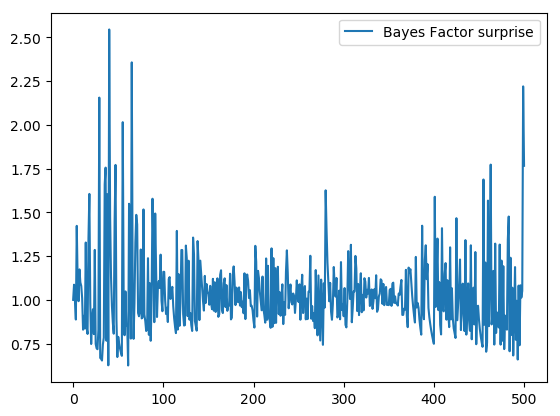

In [15]:
# set callback
callback = Callback((rule, x_t, cols) -> rule.getsbf(x_t, cols), Float64)

# decode sequence 
leaky_integration.reset()
sbfs = decode(seq, leaky_integration, callback)

# plot surprises
plot(sbfs, label="Bayes Factor surprise")
legend();

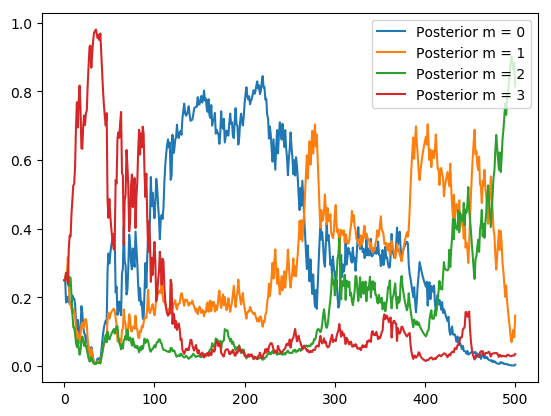

In [16]:
# set callback
callback = Callback((rule, x_t, cols) -> copy(rule.getposterior()), Array{Float64,1})

# decode sequence
leaky_integration.reset()
posterior = decode(seq, leaky_integration, callback) |> unwrap # unwrap transforms the Array of Array to a 2-D Array

# plot posterior
plot(posterior)
legend(map(i -> "Posterior m = $(i-1)", eachindex(leaky_integration.getposterior())));

<br>

Instead of having to manually define the callback each time, the file [regression.jl](regression.jl) defines some handy functions.

In [17]:
include("../regression.jl");

In [18]:
?decodessh

search: decodessh decodesbftheta decodeposterior



```
decodessh(seq, rule)
```

Decode the sequence `seq` using the learning rule `rule`, and  compute the Shannon surprise for each observation.


In [19]:
?decodesbftheta

search: decodesbftheta



```
decodesbftheta(seq, rule)
```

Decode the sequence `seq` using the learning rule `rule`, and  compute the Bayes Factor surprise and the expected value of theta for each observation.


In [20]:
?decodeposterior

search: decodeposterior



```
decodeposterior(seq, rule)
```

Decode the sequence `seq` using the learning rule `rule`, and  compute the posterior at each observation.


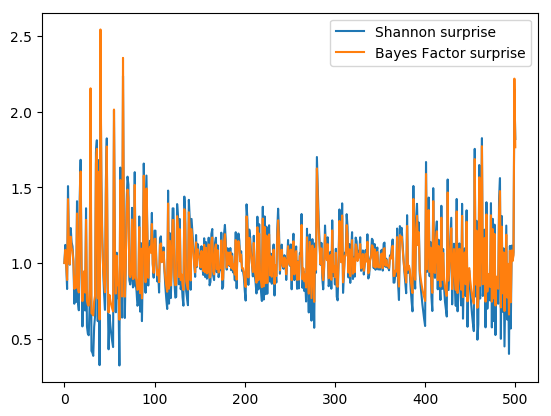

In [21]:
ssh = decodessh(seq, leaky_integration)
sbf, theta = decodesbftheta(seq, leaky_integration)

plot(ssh, label="Shannon surprise")
plot(sbf, label="Bayes Factor surprise")
legend();

<br>

## Loading subject data

Originally, the subject data files are in `.mat` format. Loading these files (~ 1GB) takes around 30-40 seconds. For this reason, the possibility to transform the files to the `.jld2` format is given, with a new loading time of around 5 seconds.

In [22]:
include("../SubjectData.jl");

In [23]:
# load .mat file directly
# takes approximately 40 seconds
subjectdata1 = load_subjectdata(
    get_filename(1, "../../../../../../../Documents/human_sequence_inference_data")
);

In [ ]:
# transforms all MAT files in folder to JLD2
transform_mat_to_jld2("../../../../../../../Documents/human_sequence_inference_data")

In [24]:
# load .jld2 file
# takes approximately 5 seconds
subjectdata2 = load_jld2(
    get_jld2_filename(2, "../../../../../../../Documents/human_sequence_inference_data/jld2")
);

In [25]:
?SubjectData

search: SubjectData subjectdata2 subjectdata1 load_subjectdata



```
SubjectData(seq, seqidx, meg, megidx, time, megdata)
```

Constructs a new structure holding subject data.


In [26]:
# the 4 blocks are the 4 conditions
subjectdata1.seq

4-element Array{Array{Int64,1},1}:
 [1, 1, 1, 0, 1, 1, 0, 0, 1, 1  …  1, 0, 1, 1, 0, 0, 0, 0, 1, 1]
 [1, 0, 1, 0, 1, 1, 1, 1, 1, 0  …  1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
 [1, 1, 1, 0, 0, 1, 1, 1, 0, 1  …  0, 0, 0, 0, 1, 0, 0, 1, 1, 0]
 [1, 1, 1, 1, 0, 1, 0, 1, 1, 0  …  0, 1, 1, 0, 1, 1, 1, 1, 1, 1]

In [27]:
# 357 sequence elements in block 1 x 306 sensors x 321 time-points
subjectdata1.meg[1]

357×306×321 Array{Float64,3}:
[:, :, 1] =
  6.13979e-14   5.21723e-14   3.04582e-15  …   1.2838e-12    6.51323e-13
 -1.45486e-13  -8.56473e-14  -2.53652e-13     -5.0346e-12   -3.33798e-12
 -1.77411e-13  -2.90721e-13  -3.77512e-13     -1.23906e-12  -3.1521e-14 
 -2.28347e-13  -3.08908e-13  -2.3151e-13      -1.60903e-13   3.47363e-12
  9.76807e-14   1.70691e-13   2.60468e-13      1.58506e-12   3.38602e-12
  2.46907e-13   3.45212e-13   3.32461e-13  …  -2.16011e-12  -5.38664e-12
 -2.73564e-14   1.3868e-13    1.24876e-13     -3.41305e-12  -1.1959e-12 
 -5.47941e-14  -2.38568e-13  -2.60083e-13     -8.16977e-13  -2.02444e-13
 -1.74073e-13  -2.25279e-14  -5.98633e-14     -1.23592e-12   3.56471e-12
  1.11198e-13   9.44247e-14   1.52267e-13      1.45213e-12   4.56554e-12
 -1.14362e-14   1.90778e-13   2.39622e-13  …   1.44383e-13  -2.0579e-12 
  9.09614e-14   5.02513e-14   3.2247e-14      -3.31015e-13  -6.5427e-13 
 -1.04316e-13   2.37852e-14   1.92931e-13      3.04977e-12  -1.47665e-14
  ⋮      

<br>

## Other use-cases

The other notebooks contain the following procedures:
- `compare.ipynb`: compare this code with the one of Maheu et al., to make sure the results are consistent

- `inference.ipynb`: some exploratory plots to determine if inference over window lengths is good / bad enough (high posterior probability for $m > 0$ for random sequences when the probability of a 1 is either very high or very low)

- `plot.ipynb`: plot the behaviour of inference / no-inference models for random sequences

- `regression.ipynb`: Fig. 5A and 5B from Maheu, et al. (regression and max $R^2$)

- `bms_bma.ipynb`: Fig. 5D and 5E from Maheu, et al. (Bayesian Model Selection and Bayesian Model Averaging)